In [206]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

In [207]:
df = pd.read_csv('data.csv')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [208]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.set_index('date', inplace=True)

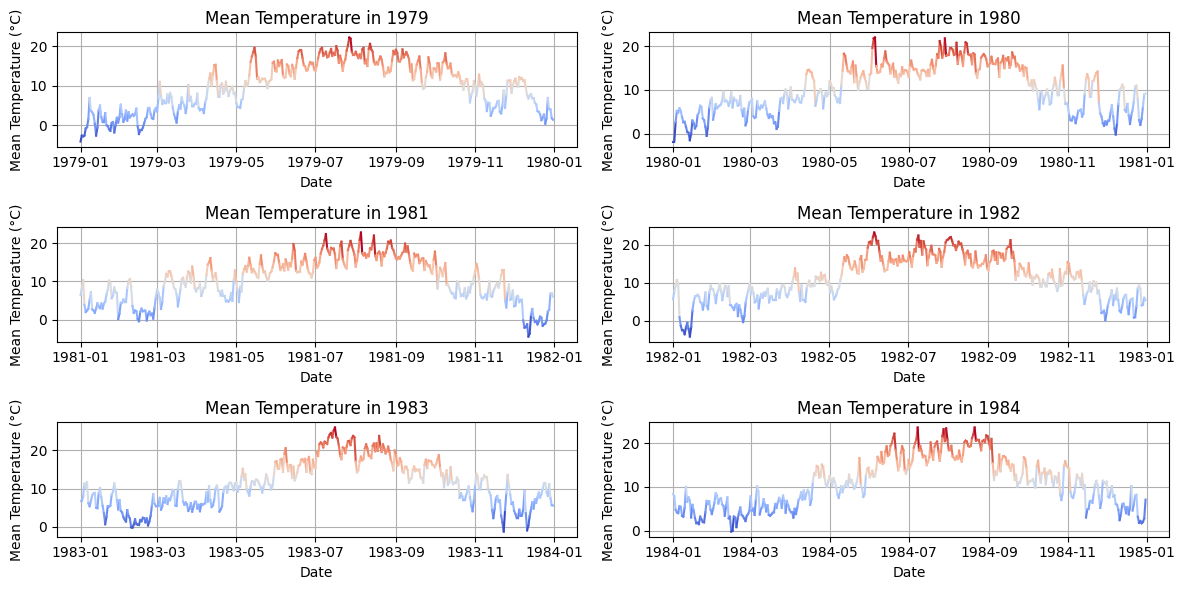

In [209]:
years = df.index.year.unique()

# Generate a colormap
cmap = cm.get_cmap('coolwarm')

fig, axs = plt.subplots(len(years[:6]) // 2 + len(years[:6]) % 2, 2, figsize=(12, 6))

for ax, year in zip(axs.flatten(), years[:6]):
    # Get the temperatures for this year
    temps = df[df.index.year == year]['mean_temp']

    # Normalize the temperatures to the range [0, 1]
    norm = plt.Normalize(min(temps), max(temps))

    # Generate a color for each temperature
    colors = cmap(norm(temps))

    for i in range(len(temps)-1):
        ax.plot(df[df.index.year == year].index[i:i+2], temps[i:i+2], color=colors[i])
    ax.set_title(f'Mean Temperature in {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Temperature (°C)')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [210]:
df.isnull().sum()

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [211]:
df.fillna((df.ffill() + df.bfill()) / 2, inplace=True)
df.isnull().sum()

cloud_cover           0
sunshine              0
global_radiation      0
max_temp              0
mean_temp             0
min_temp              0
precipitation         0
pressure              0
snow_depth          366
dtype: int64

In [212]:
df.corrwith(df['mean_temp']).sort_values(ascending=False)

mean_temp           1.000000
min_temp            0.955514
max_temp            0.912246
global_radiation    0.636154
sunshine            0.396902
pressure            0.004819
precipitation      -0.010812
cloud_cover        -0.111802
snow_depth         -0.152813
dtype: float64

In [213]:
df.drop(['pressure', 'precipitation', 'cloud_cover','snow_depth'], axis=1, inplace=True)

In [214]:
df.head()

,sunshine,global_radiation,max_temp,mean_temp,min_temp
date,,,,,
1979-01-01,7.0,52.0,2.3,-4.1,-7.5
1979-01-02,1.7,27.0,1.6,-2.6,-7.5
1979-01-03,0.0,13.0,1.3,-2.8,-7.2
1979-01-04,0.0,13.0,-0.3,-2.6,-6.5
1979-01-05,2.0,29.0,5.6,-0.8,-1.4


In [215]:
def create_sliding_window(df, window_size):
    X = []
    y = []

    for i in range(len(df) - window_size + 1):
        window = df[i:i+window_size]
        X.append(window.drop('mean_temp', axis=1))
        y.append(window['mean_temp'].values[-1])

    return np.array(X), np.array(y)

In [216]:
window_size = 5

In [217]:
X, y = create_sliding_window(df, window_size)
X_2d = X.reshape((X.shape[0], -1))

X_df = pd.DataFrame(X_2d)
y_df = pd.DataFrame(y, columns=['mean_temp'])

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
X_train = X_train.values.reshape((X_train.shape[0], 5, -1))
X_test = X_test.values.reshape((X_test.shape[0], 5, -1))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12269, 5, 4)
X_test shape: (3068, 5, 4)
y_train shape: (12269, 1)
y_test shape: (3068, 1)


In [293]:
model = Sequential()
model.add(LSTM(units=2048, activation='relu', input_shape=(window_size, X_train.shape[2]),return_sequences=True))
model.add(LSTM(units=1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')


In [294]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1, restore_best_weights=True)

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])
model.summary()
model.load_weights('./best_model.h5')


Epoch 1/200
384/384 [==============================] - ETA: 0s - loss: 5.9674
Epoch 1: val_loss improved from inf to 0.81109, saving model to ./best_model.h5


/opt/homebrew/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


384/384 [==============================] - 94s 239ms/step - loss: 5.9674 - val_loss: 0.8111
Epoch 2/200
384/384 [==============================] - ETA: 0s - loss: 1.0813
Epoch 2: val_loss improved from 0.81109 to 0.26231, saving model to ./best_model.h5
384/384 [==============================] - 90s 236ms/step - loss: 1.0813 - val_loss: 0.2623
Epoch 3/200
384/384 [==============================] - ETA: 0s - loss: 0.8472
Epoch 3: val_loss did not improve from 0.26231
384/384 [==============================] - 95s 249ms/step - loss: 0.8472 - val_loss: 0.9292
Epoch 4/200
384/384 [==============================] - ETA: 0s - loss: 0.7973
Epoch 4: val_loss did not improve from 0.26231
384/384 [==============================] - 102s 267ms/step - loss: 0.7973 - val_loss: 0.8241
Epoch 5/200
384/384 [==============================] - ETA: 0s - loss: 0.8024
Epoch 5: val_loss did not improve from 0.26231
384/384 [==============================] - 92s 240ms/step - loss: 0.8024 - val_loss: 0.2976
Ep

In [297]:
X_test[0]

array([[ 3.5, 65. , 11.5,  1.1],
       [ 0.1, 27. , 12.9,  5.7],
       [ 4.4, 70. , 13.3,  7. ],
       [ 4.9, 72. , 16.2,  6.5],
       [ 0. , 23. , 14. ,  7.4]])

In [299]:
y_test.values

array([[11.8],
       [15. ],
       [15.8],
       ...,
       [ 6.2],
       [ 7.1],
       [11. ]])

In [301]:
y_pred = model.predict(X_test)
y_pred

96/96 [==============================] - 4s 47ms/step


array([[11.592749 ],
       [14.625965 ],
       [16.058748 ],
       ...,
       [ 6.1576643],
       [ 7.1117306],
       [10.759901 ]], dtype=float32)

In [302]:
model.evaluate(X_test, y_test)

96/96 [==============================] - 5s 49ms/step - loss: 0.1916


0.1916407197713852

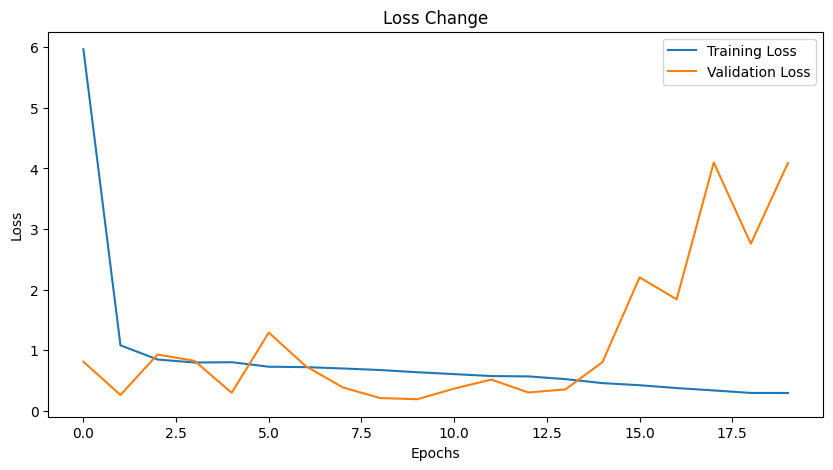

In [303]:
import matplotlib.pyplot as plt

# Get the loss and accuracy history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Change')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


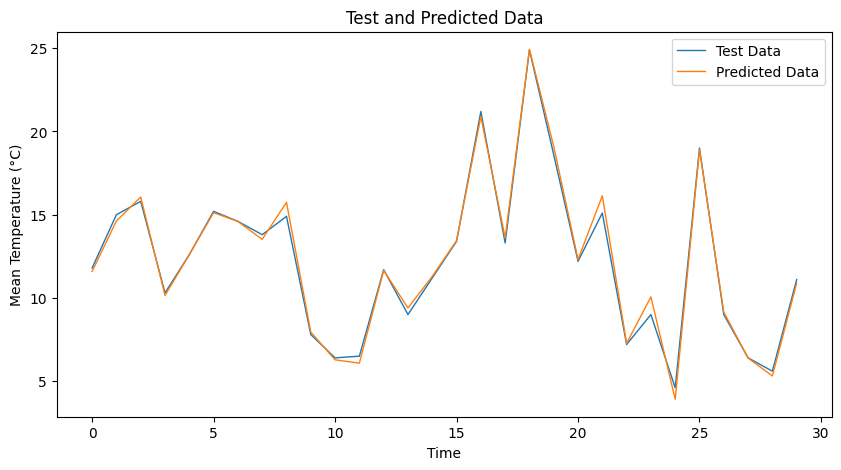

In [304]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:30], label='Test Data',linewidth=1)
plt.plot(y_pred[:30], label='Predicted Data',linewidth=1)
plt.title('Test and Predicted Data')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()